In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import os, sys
import glob
from math import *
from scipy.ndimage import gaussian_filter1d
import scipy

sns.set_style("ticks")

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/margotl/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log', 'radians', 'frexp', 'floor', 'fabs', 'cos', 'e', 'sin', 'hypot', 'log2', 'nan', 'tan', 'sqrt', 'log10', 'ldexp', 'isclose', 'log1p', 'pi', 'tanh', 'fmod', 'trunc', 'gamma', 'modf', 'cosh', 'isnan', 'exp', 'ceil', 'isfinite', 'sinh', 'inf', 'copysign', 'isinf', 'gcd', 'expm1', 'degrees']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
### This is the only cell you need to change

in_dir='/Users/margotl/Documents/GitHub/acute_assay/Images/'

data1 = np.load(in_dir+'N2old_N2June_idh-2_idhg-2_KCN_03oct19_01.npy')

save_dir='/Users/margotl/Documents/GitHub/acute_assay/'

titl='test'
date='03oct2019'


concs = [500,400,300,250,200,150,100,0] 

rep1=pd.DataFrame({
    'phenotype':pd.Categorical([
        "WT old",
        "WT",
        "idh-2",
        "idhg-2",
    ]),
    'data':[
        data1[:,(0,4,8,10),:], #WT old
        data1[:,(1,5,9,11),:], #WT June
        data1[:,2:4,:], #idh-2
        data1[:,6:8:], #idhg-2
    ],
    'drug':"M9",
    'bio_rep':1
})
reps=[rep1]

med=False # For multiple biological reps, this determines if you want to take the median of your reps.


In [22]:
# This is just boilerplate code to make the figures look good
sizer = 25
def format_figure(ax):
    '''Standard format to apply to all plots'''
    
    title_size = 30#sizer * 1.5
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(sizer)
    for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
        item.set_fontsize(title_size)    
    
    #plt.setp(ax.spines.values(), linewidth=2)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    
    return ax

def format_legend(legend):
    for label in legend.get_texts():
        label.set_fontsize(sizer*0.8)

    for label in legend.get_lines():
        label.set_linewidth(10)  # the legend line width
        
    return legend
        

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def wide_to_long(d):
    if np.ndim(d)==3:
        l=np.shape(d)[1]
        split_data=np.concatenate([d[:,range(0,l,2),:],d[:,range(0,l,2),:]],0)
    elif np.ndim(d)==2:
        l=np.shape(d)[0]
        split_data=np.stack([d[range(0,l,2),:],d[range(0,l,2),:]],0)

    newshape_data=np.swapaxes(split_data,0,1)
    return newshape_data

sns.set_style("ticks")


# Set your default plot settings here.
what_for=0
if what_for==0: #for computer display
    leg_pos=0 #0 for upper left, 1 for upper right
    l=None #width of lines
    e=None #width of errorbars
    ec=None #color of errorbars
    y=1.6 #ylim
elif what_for==1: #for presentation
    leg_pos=1 #0 for upper left, 1 for upper right
    l=4 #width of lines
    e=1.5 #width of errorbars
    ec="black"
    y=1.5 #ylim

In [23]:
## Some default normalization methods, change if desired.
def N2_norm(data):
    norm=(data
          .query('phenotype=="WT"|phenotype=="GFP"')
          .query('concentration==0')
          .groupby(['bio_rep','timepoint','drug'])
          .mean()
          .reset_index()
         .assign(norm_method='N2_norm'))
    r=(data
       .reset_index()
       .merge(norm,on=["bio_rep","timepoint",'drug']))
    return(r)

def con_norm(data):
    norm=(data
          .query('concentration==0')
          .groupby(['bio_rep','timepoint','phenotype','drug'])
          .mean()
          .reset_index()
         .assign(norm_method='con_norm'))
    r=(data
       .reset_index()
       .merge(norm,on=["bio_rep","timepoint","phenotype",'drug']))
    return(r)

def dose_norm(data):
    norm=(data
          .query('phenotype=="WT"|phenotype=="GFP"')
          .groupby(['bio_rep','timepoint','concentration','drug'])
          .mean()
          .reset_index()
         .assign(norm_method='dose_norm'))
    r=(data
       .reset_index()
       .merge(norm,on=["bio_rep","timepoint","concentration",'drug']))
    return(r)

In [24]:
## This is the code which converts the NumPy files into panda
def make_longdata(data):
    for r in range(data.shape[0]):
        index=pd.MultiIndex.from_product([concs,
                                          range(np.shape(data.iloc[r]['data'])[1]),
                                          range(10,(10*np.shape(data.iloc[r]['data'])[2]+1),10),
                                          [data.iloc[r]['phenotype']],
                                          [data.iloc[r]['drug']],
                                          [data.iloc[r]['bio_rep']]
                                         ],
                        names=['concentration','tech_rep', 'timepoint','phenotype','drug','bio_rep'])
        t=(pd.DataFrame({'mobility_score':data.iloc[r]['data']
                         .flatten()},index=index))
        if r==0:
            final=t
        else:
            final=pd.concat([final,t])
        final=(final.mask(final.mobility_score==0,0.00001))
    return(final)

## This stitches together your normzalization methods
def all_norm(data):
    norm=[]
    for n in [N2_norm,con_norm,dose_norm]:
        norm.append(n(data))
    return(pd.concat(norm))


In [25]:
l=[]
for r in reps:
    l.append(make_longdata(r))
all_reps=pd.concat(l)

r=(all_norm(all_reps)
      .assign(log2FMS=lambda x:log2(x['mobility_score_x'])-log2(x['mobility_score_y']),
             FMS=lambda x:x['mobility_score_x']/x['mobility_score_y']))
if (med):
    r=(r
      .groupby(['concentration','phenotype','drug','bio_rep','timepoint','norm_method'])
      .median())
else:
    r=r.set_index(['concentration','phenotype','drug','bio_rep','timepoint','norm_method'])

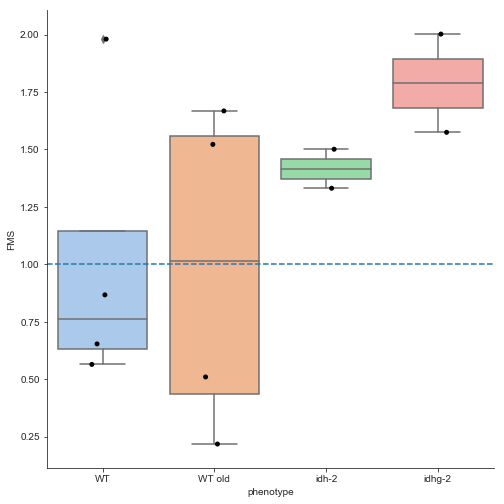

In [26]:
## Makes a boxplot of the assay data.

selected_norm=r
save=True

# Timepoints of interest.
tps=[170,180,190]

## Which non-control strains you're intereested in , optional.
mts=[]

## Set norm method, drug and concentration of interest.
dt=(r.query("norm_method=='dose_norm'&drug=='M9'&concentration==200")
 .reset_index()
 )

if len(mts)!=0:
    dt = (dt
          .groupby("bio_rep")
          .filter(lambda x: (x.phenotype.isin(mts)).any()))
    mts.extend(["WT"])
    dt=(dt[dt.phenotype.isin(mts)])

dt=dt[dt.timepoint.isin(tps)]
           
dt=(dt
    .groupby(['concentration','phenotype','bio_rep','tech_rep'])
     .median()
     .loc[:,['FMS','log2FMS']]
    .reset_index())

plt.figure(figsize=(7,7))
g=sns.boxplot(data=dt,
              #kind='box',
              y='FMS',
              x='phenotype',
              palette="pastel")
              #hue='concentration')


g=sns.stripplot(data=dt,
              y='FMS',
              x='phenotype',
              #hue='concentration',
             jitter=True,
             dodge=True,
             color='black')
g.axhline(1, ls='--')
sns.despine()
#plt.yscale('log')
plt.tight_layout(pad=0.7, w_pad=1, h_pad=1)

# Save/Show the finished plot!
if save:    
    dir_time_plot=save_dir+'idh_boxplot_dose_norm_18hr_3avg.pdf'
    plt.savefig(dir_time_plot)
plt.show()



/Users/margotl/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/margotl/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


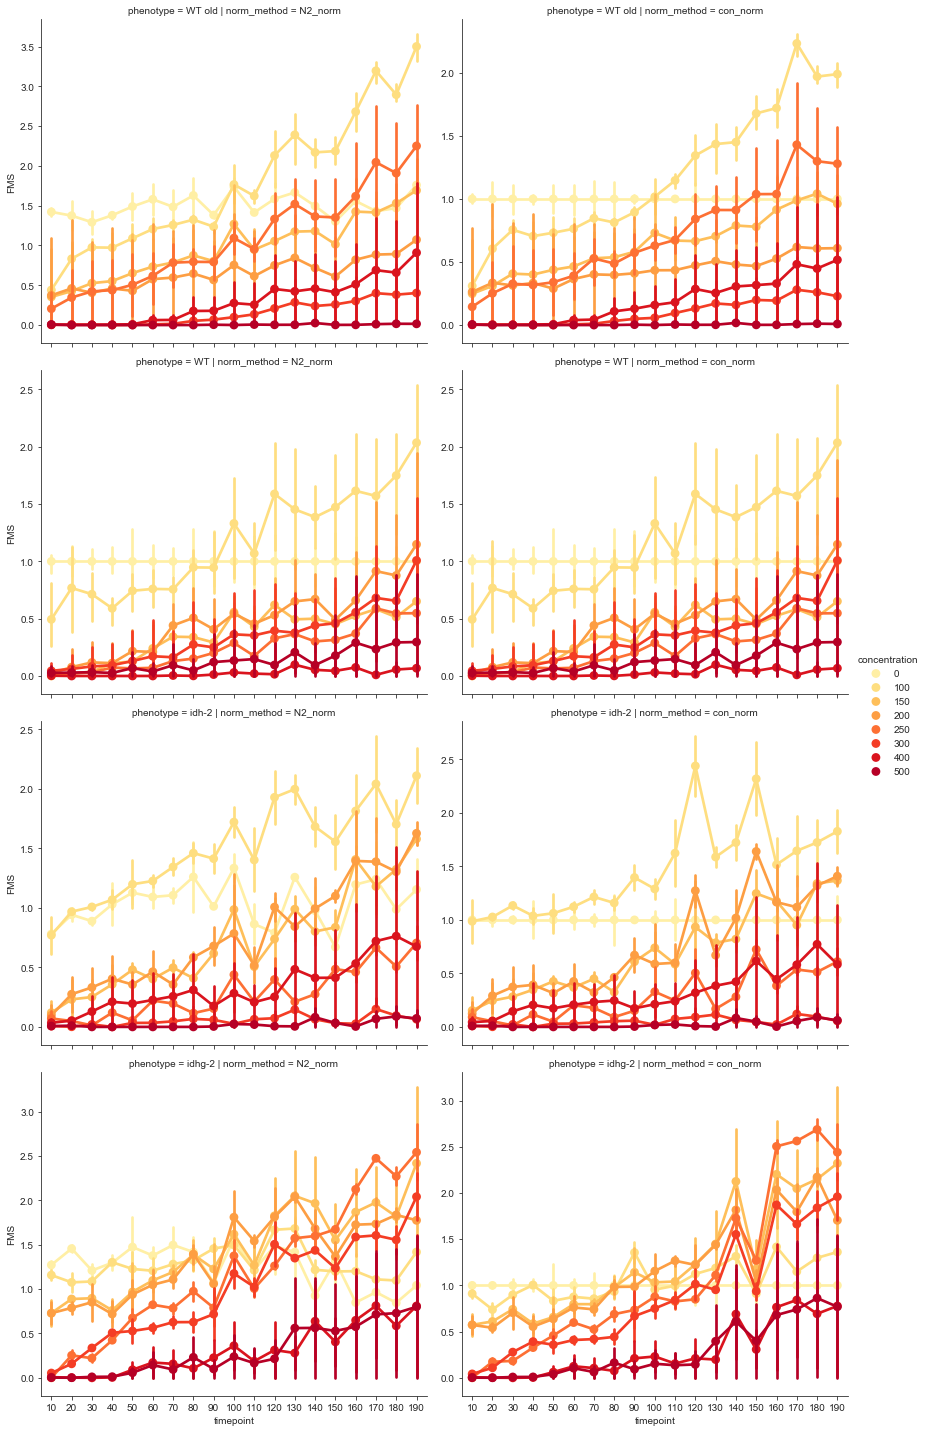

In [27]:
selected_norm=r.query("norm_method!='dose_norm'&drug=='M9'")

errorbars=True
save=False

g=sns.factorplot(x='timepoint',
                y='FMS',
                data=(selected_norm
                      .reset_index()),
                hue='concentration',
                row='phenotype',
                col='norm_method',
                 #col_wrap=3,
                palette="YlOrRd",
                aspect=1.2,
                sharey=False)

# Save/Show the finished plot!
if save:    
    dir_time_plot=save_dir+'timecourse_18hr.png'
    plt.savefig(dir_time_plot)
plt.show()

